<img src="https://www.wellcomeconnectingscience.org/wp-content/themes/new_wellcome_connecting_science/dist/assets/svg/logo.svg" alt="WCS Logo" width="150" style="float: left;">
<img src="https://github.com/EveliaCoss/Tutorial_ISCB_LATAM_scATACseq/blob/main/Logo_JAGUAR.png?raw=true" alt="WCS Logo" width="150" style="float: right;">





<h1><center>
 Practical 9: Integration of multiple batches
  </center>
  
## About the course 📌

This course is part of the Workshop [Single Cell Genomic Approaches to Study the Immune System - Latin America & the Caribbean](https://coursesandconferences.wellcomeconnectingscience.org/event/single-cell-genomic-approaches-to-study-the-immune-system-latin-america-the-caribbean-20241109/) (9-11 Novembrer 2024), Universidad CES, Medellín, Colombia.

- **Date:** 10 November 2024
- **Course duration**: 1 hour

**Speakers:**
- <font color='orange'>Danilo Ceschin</font> - PI, Centro de Investigación en Medicina Tralaslacional “Severo R. Amuchástegui” (CIMETSA), Instituto Universitario de Ciencias Biomédicas de Córdoba, Argentina.
- <font color='orange'>Felipe Gajardo</font> - PostDoc, Laboratory of Epigenetics, Pontificia Universidad Catolica de Chile.

If you want to come back to the Github, please follow the next link:
*   Github: https://github.com/WCSCourses/Single_Cell_Genomics_ImmuneSys_24


<center>

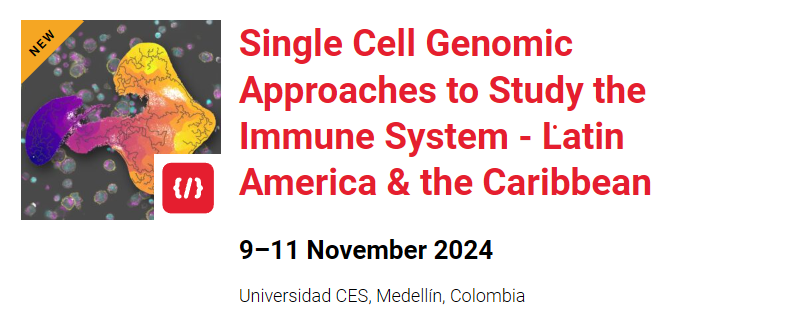

</center>

# 1️⃣ **Setting Up the Environment in Google Colab** 💻

## 1.1. Cleaning the R environment
This step is used to clean up the R environment. By removing all objects with rm(list=ls()), you ensure that no previous variables interfere with your current analysis. Running gc() triggers garbage collection, which helps manage memory usage, especially important when working with large CITE-Seq datasets.

In [ ]:
### clean environment
rm(list=ls())
gc()


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,667027,35.7,1463721,78.2,1364414,72.9
Vcells,1243819,9.5,8388608,64.0,1955829,15.0


## 1.2. Custom Shell Call Function for Google Colab
Google Colab typically runs Python as the default environment. This function lets you run shell commands from within R, ensuring compatibility with Colab’s infrastructure. It captures and prints the output of the shell commands. This functionality is useful when managing system configurations or installing packages in Colab while using the R kernel.



In [ ]:
## https://stackoverflow.com/questions/70025153/how-to-access-the-shell-in-google-colab-when-running-the-r-kernel
shell_call <- function(command, ...) {
  result <- system(command, intern = TRUE, ...)
  cat(paste0(result, collapse = "\n"))
}

## 1.3. Downloads and sets up the R2U
In this section, the script downloads and sets up the R2U repository for package management. R2U is a fast way to install R packages on Ubuntu (the operating system underlying Google Colab). This makes package installation quicker and more efficient. The script sets the appropriate permissions for the downloaded shell script, runs it, and then enables the bspm package for managing packages. After installation, the script is removed.

This is an important step to streamline package installations, reducing the time needed for installing necessary libraries for CITE-Seq data analysis, and ensuring that your environment is properly configured for your workflow.

In [ ]:
## Setup R2U
download.file("https://github.com/eddelbuettel/r2u/raw/master/inst/scripts/add_cranapt_jammy.sh",
              "add_cranapt_jammy.sh")
Sys.chmod("add_cranapt_jammy.sh", "0755")
shell_call("./add_cranapt_jammy.sh")
bspm::enable()
options(bspm.version.check=FALSE)
shell_call("rm add_cranapt_jammy.sh")


52 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists...
Building dependency tree...
Reading state information...
ca-certificates is already the newest version (20240203~22.04.1).
gnupg is already the newest version (2.2.27-3ubuntu2.1).
wget is already the newest version (1.21.2-2ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 52 not upgraded.
-----BEGIN PGP PUBLIC KEY BLOCK-----

mQINBFM+sY8BEADA70T+U0/2WNjOTLvytuXLvBC4vgA8hYvOaBS1cL3d8lu4mwr4
W84/6p4v/mXle/0eIO2D2g+XfK72ZHZxpS+bb7yPxrkCDLGxwUd/khtTJHSbbKFo
J73AsABflMe+8qv+E74+QTiXErTCNioFRz18sa0EvOnEAiokau6TZVYY2z9YjBNI
yEjTi+z+g8c1RL6VmrFEpTicTpafOLbkRyw0VKnAKG7Ytp3Ksc1G9/IAoKw3Q9La
0DJb5iX6hyB7+PNid6htK4LtPKZ2dNSrnRvNNkjj5BgcM2AT1hmxbzHNzIVmPoKA
CQFrkdjog3/PcyjdtZG7cfoSDXrbIAZeAa2ngLv9C/DJatVDd6maPOe66gLo7+As
ErMvO9vtiouqLdurW+Lhx0jFW9Ca3g1taLfbSDyS3X1mOGWcisbQvBqkIuoDQTeS
V4Z04wrwTZ1HtweKG/s5fmPtZNGWVI5YNRLIwdmbGzFTMPu2XTAOd+xSK2H+46Kh
Sh4kFeP6pBh5No4ET1MzIuDAHwl0J+mbWKPH4tIosYkcVmv

Tracing function "install.packages" in package "utils"



## 1.4. Install and Load Required Packages
This function is essential for setting up your CITE-Seq analysis environment in R. It ensures that all required packages are installed and loaded, which is crucial when working with multiple packages for data visualization, statistical analysis, or single-cell analysis in CITE-Seq.

For this tutorial, we will need the followings packages:

+ `Seurat`, the swiss-knife toolkit for analysing single-cell data in R.
+ `ggplot2`, is a system for declaratively creating graphics, based on The Grammar of Graphics.
+ `patchwork`, is a package designed to make plot composition in R extremely simple and powerful.

In [ ]:
loadAndInstallPackages <- function(pkgs) {
  # Function to load packages with suppressed warnings and messages
  myrequire <- function(pkg) {
    suppressWarnings(suppressMessages(suppressPackageStartupMessages(require(pkg, character.only = TRUE))))
  }

  # Check which packages are not installed
  new.pkgs <- pkgs[!(pkgs %in% installed.packages()[, "Package"])]

  # Install missing packages
  if (length(new.pkgs) > 0) {
    message("Installing the following packages: ", paste(new.pkgs, collapse = ", "))
    if (!requireNamespace("BiocManager", quietly = TRUE))
      install.packages("BiocManager")
    BiocManager::install(new.pkgs, dependencies = TRUE)
  }

  # Load all packages, including newly installed ones
  ok <- sapply(pkgs, myrequire)

  # Report if any package could not be loaded
  if (!all(ok)) {
    message("The following packages could not be loaded: ", paste(pkgs[!ok], collapse = ", "))
  } else {
    message("All packages were successfully loaded.")
  }
}

packages <- c("Seurat", "tidyverse")

# installation and/or calling packages
loadAndInstallPackages(packages)

All packages were successfully loaded.



# 2️⃣ **Download and Uncompress CITE-Seq Count**

The count matrices contain the core data for single-cell multimodal analysis, including RNA and protein expression levels. Accessing this data is the foundational step for conducting subsequent analyses, such as exploring gene expression patterns or protein marker abundance across different cell types.

In [ ]:
system("wget https://github.com/WCSCourses/Single_Cell_Genomics_ImmuneSys_24/raw/refs/heads/main/course_data/Module2_CITEseq/10X_multimodal_dataset_downsample3000.tar.gz")
system("tar xf 10X_multimodal_dataset_downsample3000.tar.gz")


system("wget https://github.com/WCSCourses/Single_Cell_Genomics_ImmuneSys_24/raw/refs/heads/main/course_data/Module2_CITEseq/COMBAT_frac0_02_MEX.tar.gz")
system("tar xf COMBAT_frac0_02_MEX.tar.gz")

#3\. Creating and Processing Seurat Objects for CITE-Seq Integration Analysis

In this section, we create **two Seurat objects** and process them individually for downstream analysis. RNA and ADT matrices of each object are normalized using LogNormalize and CLR, respectively. Then, they are scaled, subjected to dimensionality reduction, and finally used for predicting clusters. This setup allows for concurrent analyzis of both RNA and protein expression, making the full use of multi-modal data.

In [ ]:
# Dataset 1
prot=Read10X("YASCP_downsample_3000_MEX_ADT")
rna=Read10X("YASCP_downsample_3000_MEX_GEX")

# Dataset 2
prot.combat=Read10X("ADT_MEX_frac0.02")
prot.combat=prot.combat[, colnames(prot.combat) != "GGCGTGTAGTCGTTTG-1-gPlexA4"] # <- the ADT matrix has an extra cell
                                                                                   #    that shouldn't be there. We will
                                                                                   #    exclude it and reorder the RNA
                                                                                   #    matrix in order to avoid errors.
rna.combat=Read10X("GEX_MEX_frac0.02")
rna.combat=rna.combat[, colnames(prot.combat)] # <- reorder


# create Seurat object note: min.cells is a gene filter, not a cell filter
s1 = Seurat::CreateSeuratObject(counts = rna,
                               project="Batch_1",
                                                              #meta.data = cellmd,
                               assay = "RNA",
                               min.cells = 20)
DefaultAssay(s1)="RNA"
s1=NormalizeData(s1, normalization.method="LogNormalize", assay="RNA")
s1=ScaleData(s1, features = rownames(s1))
s1=FindVariableFeatures(s1)
s1=RunPCA(s1)
s1=RunUMAP(s1, dims = 1:50)
s1=FindNeighbors(s1, dims=1:50)
s1=FindClusters(s1)

# add dsb normalized matrix "cell.adt.dsb" to the "CITE" data (not counts!) slot
s1@assays$CITE = Seurat::CreateAssayObject(counts = prot)
DefaultAssay(s1)="CITE"
s1=NormalizeData(s1, normalization.method="CLR", assay="CITE")

# create Seurat object note: min.cells is a gene filter, not a cell filter
s2 = Seurat::CreateSeuratObject(counts = rna.combat,
                               project="Batch_2",
                               #meta.data = cellmd,
                               assay = "RNA",
                               min.cells = 20)
DefaultAssay(s2)="RNA"
s2=NormalizeData(s2, normalization.method="LogNormalize", assay="RNA")
s2=ScaleData(s2, features = rownames(s2))
s2=FindVariableFeatures(s2)
s2=RunPCA(s2)
s2=RunUMAP(s2, dims = 1:50)
s2=FindNeighbors(s2, dims=1:50)
s2=FindClusters(s2)

# add dsb normalized matrix "cell.adt.dsb" to the "CITE" data (not counts!) slot
s2@assays$CITE = Seurat::CreateAssayObject(counts = prot.combat)
DefaultAssay(s2)="CITE"
s2=NormalizeData(s2, normalization.method="CLR", assay="CITE")

batches.lst=list(s1,s2)

s1
s2


Normalizing layer: counts

Centering and scaling data matrix

Finding variable features for layer counts

PC_ 1 
Positive:  CD69, MALAT1, IFITM1, LTB, CXCR4, RPS12, IL7R, CD3D, EEF1A1, CD247 
	   CAMK4, TCF7, CD7, IL32, LEF1, LIME1, TRBC2, BACH2, ZEB1, CD5 
	   ZFP36L2, SYNE2, ABLIM1, ITM2A, RORA, CTSW, CD6, PDE3B, GZMM, CCR7 
Negative:  IFI30, LYZ, FCN1, CST3, S100A9, SPI1, S100A8, G0S2, IL1B, LST1 
	   CSTA, TNFAIP2, CTSS, TYROBP, S100A11, SERPINA1, NLRP3, AIF1, NAMPT, FCER1G 
	   VCAN, PLAUR, ACSL1, CFD, S100A12, IFNGR2, LGALS3, HCK, CSF3R, CD68 
PC_ 2 
Positive:  NKG7, CST7, GNLY, CTSW, CCL5, GZMA, GZMB, GZMH, FGFBP2, KLRD1 
	   PRF1, HOPX, GZMM, MATK, SPON2, KLRF1, IFITM2, S1PR5, PFN1, KLRK1 
	   FCGR3A, C12orf75, CLIC3, IL2RG, CD7, KLRC2, IFITM1, KLRB1, ITGB2, S100A4 
Negative:  CD79A, LTB, MS4A1, BANK1, SNX9, AFF3, RALGPS2, HLA-DRA, LINC00926, ZEB1 
	   BACH2, FCRL1, LEF1, CCR7, FCER2, TNFRSF13C, RUBCNL, ADAM28, HLA-DRB5, COBLL1 
	   IGHM, GNG7, NIBAN3, PLEKHG1, ARHGAP24, CHPT1,

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3000
Number of edges: 145996

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8458
Number of communities: 13
Elapsed time: 0 seconds


Normalizing across features

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Normalizing layer: counts

Centering and scaling data matrix

Finding variable features for layer counts

PC_ 1 
Positive:  IL32, AB-CD2, AB-CD7, AB-CD5, AB-CD3, NPM1, CD7, AB-CD278-ICOS, IL7R, TRBC2 
	   AB-CD28, AB-CD27, CD2, HSP90AB1, CTSW, NCL, NOSIP, GZMM, ISG20, MT-ND4L 
	   SPOCK2, GZMA, ITM2A, CD27, TRBC1, CCL5, AB-CD45RA, CST7, PRF1, H4C3 
Negative:  FCN1, CST3, AB-CLEC12A, LYZ, S100A9, MNDA, AIF1, SERPINA1, S100A8, AB-CD36 
	   AB-CD64, AB-CD33, VCAN, LST1, CD14, FTL, AB-CD31, AB-CD11c, CTSS, AB-CD41 
	   TYROBP, CD68, CSTA, CYBB, GRN, AB-CD35, MS4A6A, S100A12, AB-CD58-LFA-3, FPR1 
PC_ 2 
Positive:  AB-Podoplanin, AB-CD66b, AB-humanCD11b, AB-CD24, AB-CD28, AB-CD69, AB-CD194-CCR4, AB-CD73, AB-CD5, AB-CD4 
	   AB-CD107a-LAMP-1, AB-CD26, AB-IgGFc, AB-CD35, AB-IgM, AB-Iglightchaink, AB-CD3, AB-IgA, AB-CD40, AB-CD88-C5aR 
	   AB-CD101-BB27, IL7R, AB-CD27, AB-CD3

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 835
Number of edges: 46157

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7293
Number of communities: 6
Elapsed time: 0 seconds


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Normalizing across features



An object of class Seurat 
12150 features across 3000 samples within 2 assays 
Active assay: CITE (137 features, 0 variable features)
 2 layers present: counts, data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

An object of class Seurat 
8833 features across 835 samples within 2 assays 
Active assay: CITE (192 features, 0 variable features)
 2 layers present: counts, data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

#4\. Selecting Integration Features and Preparing Data for Batch Correction

Here, we **select integration features** across the two batches (`s1` and `s2`). These shared features are critical for aligning data from multiple experiments. Next, we **scale the data** and run **PCA** for both batches using the selected integration features. This ensures that both datasets are normalized and dimensionally reduced on the same feature set, preparing them for **batch correction** and integration in subsequent steps.

In [ ]:
features = SelectIntegrationFeatures(object.list = list(s1,s2))
features

s1 = ScaleData(s1, features = features, verbose = FALSE)
s1 = RunPCA(s1, features = features, verbose = FALSE)
s2 = ScaleData(s2, features = features, verbose = FALSE)
s2 = RunPCA(s2, features = features, verbose = FALSE)

No variable features found for object1 in the object.list. Running FindVariableFeatures ...

No variable features found for object2 in the object.list. Running FindVariableFeatures ...



[1] "IgM"    "CD19"   "CD20"   "CD16"   "CD71"   "CD21"   "IgD"    "CD123" 
 [9] "CD1c"   "CD35"   "CD11c"  "CD8"    "CD33"   "CD36"   "CD22"   "CD41"  
[17] "CD49b"  "CD39"   "CD64"   "CD32"   "CD163"  "CD24"   "CD31"   "CD14"  
[25] "CD54"   "CD40"   "CD279"  "CD5"    "CD1d"   "CD86"   "CD161"  "CD146" 
[33] "CD69"   "CD27"   "CD7"    "CX3CR1" "CD2"    "CD29"   "CD18"   "CD25"  
[41] "CD45RO" "CD28"   "CD45RA" "CD49d"  "CD154"  "CD52"   "CD83"   "CD47"

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“did not converge--results might be invalid!; try increasing work or maxit”
Warning message:
“Number of dimensions changing from 50 to 47”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“did not converge--results might be invalid!; try increasing work or maxit”
Warning message:
“Number of dimensions changing from 50 to 47”


#5\. Finding Integration Anchors and Integrating Data

In this step, we use **FindIntegrationAnchors** to identify shared patterns (anchors) between the two batches (`s1` and `s2`). The `rpca` reduction method helps to correct batch effects by using reference-based integration. After finding the anchors, the **IntegrateData** function integrates both datasets into a unified latent space, which is essential for joint downstream analysis. This step ensures that the data from different batches or experiments are aligned and comparable.

In [ ]:
anchors <- FindIntegrationAnchors(object.list = list(s1,s2), reference = c(1, 2), reduction = "rpca",
    dims = 1:30)
s.integrated <- IntegrateData(anchorset = anchors, dims = 1:30)

Computing 2000 integration features

No variable features found for object1 in the object.list. Running FindVariableFeatures ...

No variable features found for object2 in the object.list. Running FindVariableFeatures ...

Scaling features for provided objects

Computing within dataset neighborhoods

Finding anchors between all query and reference datasets

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 2002 anchors

Merging dataset 2 into 1

Extracting anchors for merged samples

Finding integration vectors

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Finding integration vector weights

Integrating data

Warning message:
“Layer counts isn't present in the assay object; returning NULL”


#6\. Scaling and Dimensionality Reduction of Integrated Data

After integrating the datasets, we apply **ScaleData** to normalize and center the integrated dataset, which is crucial for accurate downstream analysis. Next, we perform **RunPCA** to reduce the dimensionality of the data, capturing the most relevant variation. Finally, we use **RunUMAP** to visualize the integrated data in a 2D space, allowing us to observe patterns and potential clusters in the combined dataset. This workflow ensures that the integrated data is ready for further exploration and analysis.

In [ ]:
s.integrated <- ScaleData(s.integrated, verbose = FALSE)
s.integrated <- RunPCA(s.integrated, verbose = FALSE)
s.integrated <- RunUMAP(s.integrated, dims = 1:30)

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“did not converge--results might be invalid!; try increasing work or maxit”
05:25:24 UMAP embedding parameters a = 0.9922 b = 1.112

05:25:24 Read 3835 rows and found 30 numeric columns

05:25:24 Using Annoy for neighbor search, n_neighbors = 30

05:25:24 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:25:25 Writing NN index file to temp file /tmp/RtmpWwci4b/file7cae4d9fe694

05:25:25 Searching Annoy index using 1 thread, search_k = 3000

05:25:27 Annoy recall = 100%

05:25:27 Commencing smooth kNN distance calibration using 1 thread
 with target n_nei

#7\. Visualization of Integrated Data by Original Identity

The **DimPlot** function generates a UMAP plot that displays the integrated data, with cells colored according to their original identity (`orig.ident`). This visualization helps us evaluate how well the datasets from different batches have been integrated and whether any batch effects remain, which is critical for assessing the quality of the integration process.

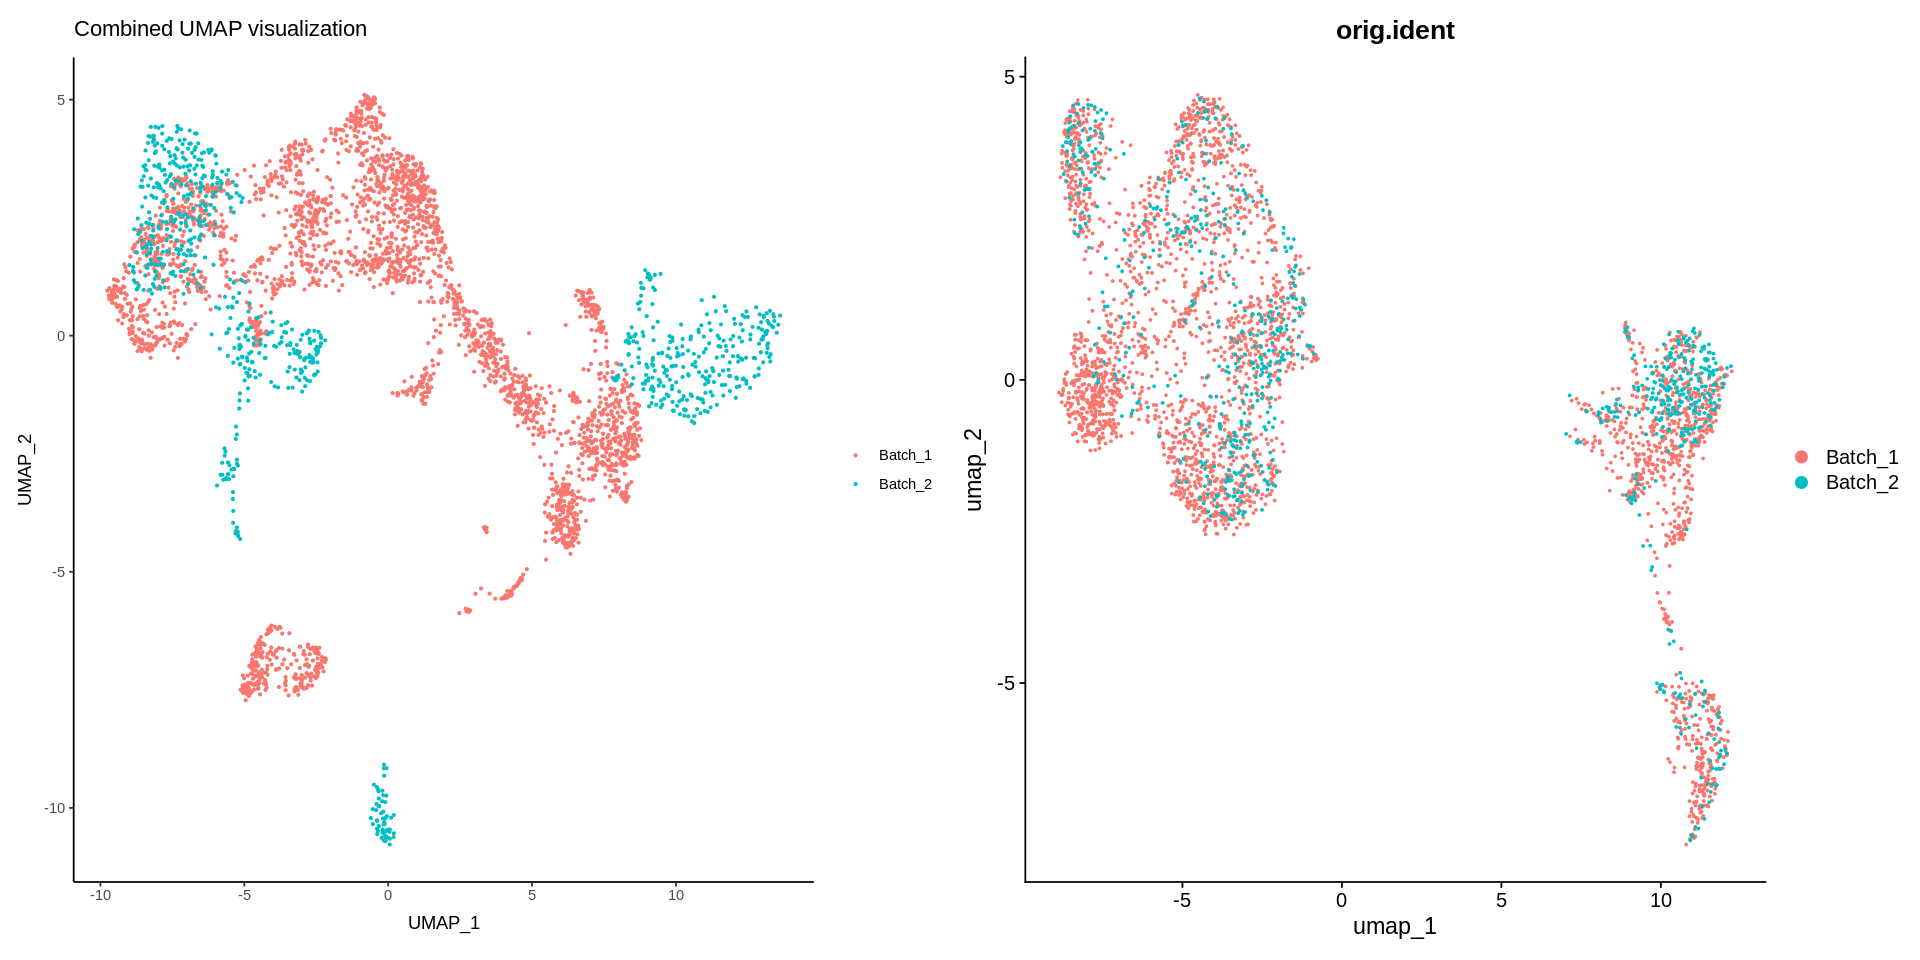

In [ ]:
# Extract UMAP coordinates from the first object (s1)
umap1 <- data.frame(
  umap_1 = Embeddings(s1, "umap")[,1],
  umap_2 = Embeddings(s1, "umap")[,2],
  dataset = "Batch_1"
)

# Extract UMAP coordinates from the first object (s2)
umap2 <- data.frame(
  umap_1 = Embeddings(s2, "umap")[,1],
  umap_2 = Embeddings(s2, "umap")[,2],
  dataset = "Batch_2"
)

# Combine data
combined_umap <- rbind(umap1, umap2)

# Create graphic using ggplot2

# Set plot size
options(repr.plot.width = 16, repr.plot.height = 8)

p1 <- ggplot(combined_umap, aes(x = umap_1, y = umap_2, color = dataset)) +
  geom_point(size = 0.5) +
  theme_classic() +
  labs(title = "Combined UMAP visualization",
       x = "UMAP_1",
       y = "UMAP_2") +
  theme(legend.title = element_blank(),
        panel.grid = element_blank(),
        panel.background = element_blank())


p2 <- DimPlot(s.integrated, group.by = "orig.ident")
p1 + p2

# References

1. https://satijalab.org/seurat/archive/v3.2/integration.html
